In [26]:
import requests
import json
from bs4 import BeautifulSoup
from IPython.core.display import HTML
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import locale
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
cik = "CIK0001341439"
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}
response = requests.get("https://data.sec.gov/api/xbrl/companyfacts/CIK0001341439.json", headers=header)
data = None
if response.ok:
    data = json.loads(response.content)
else:
    print(response.status_code)
    print(response.reason)
    print(responses.text)

In [3]:
print(list(data["facts"]["us-gaap"]))

['AccountsPayableCurrent', 'AccountsReceivableNetCurrent', 'AccruedIncomeTaxesCurrent', 'AccruedIncomeTaxesNoncurrent', 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment', 'AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossDefinedBenefitPensionAndOtherPostretirementPlansNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'AcquiredFiniteLivedIntangibleAssetAmount', 'AdjustmentsNoncashItemsToReconcileNetIncomeLossToCashProvidedByUsedInOperatingActivitiesOther', 'AdjustmentsRelatedToTaxWithholdingForShareBasedCompensation', 'AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue', 'AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensatio

In [11]:
concepts = ["CashEquivalentsAtCarryingValue","AccountsReceivableNetCurrent","InventoryNet","AssetsCurrent","PropertyPlantAndEquipmentNet","Assets","AccountsPayableCurrent","LiabilitiesCurrent","LiabilitiesNoncurrent","RetainedEarningsAccumulatedDeficit","StockholdersEquity"]


financialData = {}
for concept in concepts:
    print(concept)
    unit = "USD"
    if not unit in list(data["facts"]["us-gaap"][concept]["units"]):
        unit = "USD/shares"
        
    for element in data["facts"]["us-gaap"][concept]["units"][unit]:
        year = element["end"]
        if element["end"] in financialData:
            financialData[element["end"]][concept] = element["val"]
        else:
            financialData[element["end"]] = {f"{concept}": element["val"]} 
    print(f"{concept} processed successfully")

for year in financialData:
    if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] \
    and "StockholdersEquity" in financialData[year]:
        financialData[year]["DebtToEquityRatio"] = (financialData[year]["LiabilitiesCurrent"] 
                                                    + financialData[year]["LiabilitiesNoncurrent"]) / financialData[year]["StockholdersEquity"]
        
    if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] \
    and "AssetsCurrent" in financialData[year]:
        financialData[year]["CurrentRatio"] = financialData[year]["LiabilitiesCurrent"] / financialData[year]["AssetsCurrent"]
                                  

CashEquivalentsAtCarryingValue
CashEquivalentsAtCarryingValue processed successfully
AccountsReceivableNetCurrent
AccountsReceivableNetCurrent processed successfully
InventoryNet
InventoryNet processed successfully
AssetsCurrent
AssetsCurrent processed successfully
PropertyPlantAndEquipmentNet
PropertyPlantAndEquipmentNet processed successfully
Assets
Assets processed successfully
AccountsPayableCurrent
AccountsPayableCurrent processed successfully
LiabilitiesCurrent
LiabilitiesCurrent processed successfully
LiabilitiesNoncurrent
LiabilitiesNoncurrent processed successfully
RetainedEarningsAccumulatedDeficit
RetainedEarningsAccumulatedDeficit processed successfully
StockholdersEquity
StockholdersEquity processed successfully


In [12]:
# Convert diction of 'end of quarter dates' to list of objects with quarter as part of the object keys
dfData = []
for row in financialData:
    record = financialData[row]  # All concept data for a particular 'end of quarter'
    record["Quarter"] = row  # Add a key in the object to hold the quarter
    record["Revenue Increased"] = random.choice([0, 1])  # Set "Revenue Increased" randomly
    dfData.append(record)  # Add to list of objects
    
# Create a DataFrame from the list of objects
financialDataDF = pd.DataFrame(dfData)

# Print the data types of columns in the DataFrame
print(financialDataDF.dtypes)
    

CashEquivalentsAtCarryingValue        float64
AccountsReceivableNetCurrent            int64
InventoryNet                          float64
AssetsCurrent                           int64
PropertyPlantAndEquipmentNet            int64
Assets                                  int64
AccountsPayableCurrent                  int64
LiabilitiesCurrent                      int64
LiabilitiesNoncurrent                   int64
RetainedEarningsAccumulatedDeficit      int64
StockholdersEquity                      int64
DebtToEquityRatio                     float64
CurrentRatio                          float64
Quarter                                object
Revenue Increased                       int64
dtype: object


In [13]:
financialDataDF.head(10)

,CashEquivalentsAtCarryingValue,AccountsReceivableNetCurrent,InventoryNet,AssetsCurrent,PropertyPlantAndEquipmentNet,Assets,AccountsPayableCurrent,LiabilitiesCurrent,LiabilitiesNoncurrent,RetainedEarningsAccumulatedDeficit,StockholdersEquity,DebtToEquityRatio,CurrentRatio,Quarter,Revenue Increased
0,2.512000e+09,5585000000,259000000.0,27004000000,2763000000,61578000000,775000000,14691000000,15688000000,16146000000,30798000000,0.986395,0.544031,2010-05-31,0
1,5.702000e+09,6628000000,303000000.0,39174000000,2857000000,73535000000,494000000,14192000000,19098000000,22581000000,39776000000,0.836937,0.362281,2011-05-31,1
2,5.700000e+08,6377000000,158000000.0,40023000000,3021000000,78327000000,438000000,15388000000,18852000000,26087000000,43688000000,0.783739,0.384479,2012-05-31,1
3,1.375000e+09,6049000000,240000000.0,41692000000,3053000000,81812000000,419000000,12872000000,23795000000,25854000000,44648000000,0.821246,0.308740,2013-05-31,0
4,3.576000e+09,6087000000,189000000.0,48128000000,3061000000,90266000000,471000000,14389000000,28430000000,25965000000,46878000000,0.913414,0.298974,2014-05-31,1
5,6.063000e+09,5618000000,314000000.0,62520000000,3686000000,110903000000,806000000,15206000000,46599000000,26503000000,48663000000,1.270061,0.243218,2015-05-31,1
6,5.420000e+09,5385000000,212000000.0,64313000000,4000000000,112180000000,504000000,17208000000,47182000000,23888000000,47289000000,1.361627,0.267566,2016-05-31,0
7,5.679000e+09,5300000000,300000000.0,74515000000,5315000000,134991000000,599000000,24178000000,56567000000,27598000000,53860000000,1.499165,0.324472,2017-05-31,0
8,6.808000e+09,5136000000,398000000.0,76159000000,5897000000,137851000000,529000000,19124000000,71854000000,19111000000,46372000000,1.961917,0.251106,2018-05-31,1
9,1.062900e+10,5134000000,320000000.0,46386000000,6252000000,108709000000,580000000,18630000000,67716000000,-3496000000,21785000000,3.963553,0.401630,2019-05-31,1


In [14]:
financialDataDF.isnull().sum()

CashEquivalentsAtCarryingValue        44
AccountsReceivableNetCurrent           0
InventoryNet                          18
AssetsCurrent                          0
PropertyPlantAndEquipmentNet           0
Assets                                 0
AccountsPayableCurrent                 0
LiabilitiesCurrent                     0
LiabilitiesNoncurrent                  0
RetainedEarningsAccumulatedDeficit     0
StockholdersEquity                     0
DebtToEquityRatio                      0
CurrentRatio                           0
Quarter                                0
Revenue Increased                      0
dtype: int64

In [16]:
financialDataDF[financialDataDF["CashEquivalentsAtCarryingValue"].isnull()]

,CashEquivalentsAtCarryingValue,AccountsReceivableNetCurrent,InventoryNet,AssetsCurrent,PropertyPlantAndEquipmentNet,Assets,AccountsPayableCurrent,LiabilitiesCurrent,LiabilitiesNoncurrent,RetainedEarningsAccumulatedDeficit,StockholdersEquity,DebtToEquityRatio,CurrentRatio,Quarter,Revenue Increased
14,NaN,4430000000,0.0,18581000000,1922000000,47416000000,271000000,9149000000,12822000000,11894000000,25090000000,0.875688,0.492385,2009-05-31,0
15,NaN,2584000000,NaN,24445000000,1924000000,52998000000,260000000,9160000000,17351000000,12563000000,26143000000,1.014076,0.374719,2009-08-31,1
16,NaN,3086000000,NaN,25235000000,1956000000,53833000000,255000000,8534000000,17384000000,13541000000,27531000000,0.941411,0.338181,2009-11-30,0
17,NaN,3898000000,315000000.0,23979000000,2869000000,59386000000,616000000,14251000000,16284000000,14257000000,28476000000,1.072307,0.594312,2010-02-28,1
18,NaN,3721000000,235000000.0,30264000000,2835000000,65255000000,706000000,13800000000,18943000000,17027000000,32106000000,1.019841,0.455987,2010-08-31,0
19,NaN,4406000000,236000000.0,32723000000,2870000000,67243000000,762000000,13336000000,19057000000,18422000000,34412000000,0.941329,0.407542,2010-11-30,0
20,NaN,4495000000,276000000.0,32459000000,2894000000,67666000000,673000000,11282000000,19325000000,20059000000,36617000000,0.835869,0.347577,2011-02-28,0
21,NaN,4194000000,259000000.0,39206000000,2930000000,73859000000,614000000,13056000000,19564000000,23385000000,40892000000,0.797711,0.333010,2011-08-31,0
22,NaN,4434000000,218000000.0,38482000000,2900000000,72910000000,445000000,11072000000,19571000000,24383000000,41920000000,0.730988,0.287719,2011-11-30,1
23,NaN,4656000000,172000000.0,37538000000,2936000000,74361000000,442000000,11632000000,19463000000,25116000000,42873000000,0.725282,0.309873,2012-02-29,0


In [17]:
financialDataDF.dropna(inplace=True)

In [18]:
print(financialDataDF.isnull().sum())
print(financialDataDF.shape)

CashEquivalentsAtCarryingValue        0
AccountsReceivableNetCurrent          0
InventoryNet                          0
AssetsCurrent                         0
PropertyPlantAndEquipmentNet          0
Assets                                0
AccountsPayableCurrent                0
LiabilitiesCurrent                    0
LiabilitiesNoncurrent                 0
RetainedEarningsAccumulatedDeficit    0
StockholdersEquity                    0
DebtToEquityRatio                     0
CurrentRatio                          0
Quarter                               0
Revenue Increased                     0
dtype: int64
(14, 15)


In [19]:
for i in range(len(financialDataDF)):
    if i == 0:
        financialDataDF.iloc[i, 13] = 0
    else:
        financialDataDF.iloc[i, 13] = 1 if financialDataDF.iloc[i, 10] > financialDataDF.iloc[i-1, 10] else 0
financialDataDF.head(10)

,CashEquivalentsAtCarryingValue,AccountsReceivableNetCurrent,InventoryNet,AssetsCurrent,PropertyPlantAndEquipmentNet,Assets,AccountsPayableCurrent,LiabilitiesCurrent,LiabilitiesNoncurrent,RetainedEarningsAccumulatedDeficit,StockholdersEquity,DebtToEquityRatio,CurrentRatio,Quarter,Revenue Increased
0,2.512000e+09,5585000000,259000000.0,27004000000,2763000000,61578000000,775000000,14691000000,15688000000,16146000000,30798000000,0.986395,0.544031,0,0
1,5.702000e+09,6628000000,303000000.0,39174000000,2857000000,73535000000,494000000,14192000000,19098000000,22581000000,39776000000,0.836937,0.362281,1,1
2,5.700000e+08,6377000000,158000000.0,40023000000,3021000000,78327000000,438000000,15388000000,18852000000,26087000000,43688000000,0.783739,0.384479,1,1
3,1.375000e+09,6049000000,240000000.0,41692000000,3053000000,81812000000,419000000,12872000000,23795000000,25854000000,44648000000,0.821246,0.308740,1,0
4,3.576000e+09,6087000000,189000000.0,48128000000,3061000000,90266000000,471000000,14389000000,28430000000,25965000000,46878000000,0.913414,0.298974,1,1
5,6.063000e+09,5618000000,314000000.0,62520000000,3686000000,110903000000,806000000,15206000000,46599000000,26503000000,48663000000,1.270061,0.243218,1,1
6,5.420000e+09,5385000000,212000000.0,64313000000,4000000000,112180000000,504000000,17208000000,47182000000,23888000000,47289000000,1.361627,0.267566,0,0
7,5.679000e+09,5300000000,300000000.0,74515000000,5315000000,134991000000,599000000,24178000000,56567000000,27598000000,53860000000,1.499165,0.324472,1,0
8,6.808000e+09,5136000000,398000000.0,76159000000,5897000000,137851000000,529000000,19124000000,71854000000,19111000000,46372000000,1.961917,0.251106,0,1
9,1.062900e+10,5134000000,320000000.0,46386000000,6252000000,108709000000,580000000,18630000000,67716000000,-3496000000,21785000000,3.963553,0.401630,0,1


In [20]:
# Separator data in predictors(x) and labels(y)
predictors = financialDataDF.iloc[:,0:13]
labels = financialDataDF.iloc[:,13]
predictors.head(20)

,CashEquivalentsAtCarryingValue,AccountsReceivableNetCurrent,InventoryNet,AssetsCurrent,PropertyPlantAndEquipmentNet,Assets,AccountsPayableCurrent,LiabilitiesCurrent,LiabilitiesNoncurrent,RetainedEarningsAccumulatedDeficit,StockholdersEquity,DebtToEquityRatio,CurrentRatio
0,2.512000e+09,5585000000,259000000.0,27004000000,2763000000,61578000000,775000000,14691000000,15688000000,16146000000,30798000000,0.986395,0.544031
1,5.702000e+09,6628000000,303000000.0,39174000000,2857000000,73535000000,494000000,14192000000,19098000000,22581000000,39776000000,0.836937,0.362281
2,5.700000e+08,6377000000,158000000.0,40023000000,3021000000,78327000000,438000000,15388000000,18852000000,26087000000,43688000000,0.783739,0.384479
3,1.375000e+09,6049000000,240000000.0,41692000000,3053000000,81812000000,419000000,12872000000,23795000000,25854000000,44648000000,0.821246,0.308740
4,3.576000e+09,6087000000,189000000.0,48128000000,3061000000,90266000000,471000000,14389000000,28430000000,25965000000,46878000000,0.913414,0.298974
5,6.063000e+09,5618000000,314000000.0,62520000000,3686000000,110903000000,806000000,15206000000,46599000000,26503000000,48663000000,1.270061,0.243218
6,5.420000e+09,5385000000,212000000.0,64313000000,4000000000,112180000000,504000000,17208000000,47182000000,23888000000,47289000000,1.361627,0.267566
7,5.679000e+09,5300000000,300000000.0,74515000000,5315000000,134991000000,599000000,24178000000,56567000000,27598000000,53860000000,1.499165,0.324472
8,6.808000e+09,5136000000,398000000.0,76159000000,5897000000,137851000000,529000000,19124000000,71854000000,19111000000,46372000000,1.961917,0.251106
9,1.062900e+10,5134000000,320000000.0,46386000000,6252000000,108709000000,580000000,18630000000,67716000000,-3496000000,21785000000,3.963553,0.401630


In [21]:
# pca = PCA(n_components=3)
pca = PCA()
predictorspca = pca.fit_transform(predictors)
print(pca.explained_variance_ratio_.round(decimals=3))
predictorspca[0:5]

[0.725 0.248 0.024 0.002 0.001 0.    0.    0.    0.    0.    0.    0.
 0.   ]


array([[-5.03780593e+10, -4.02443022e+10, -7.10947783e+08,
        -2.42630474e+09,  3.56693046e+08, -5.13861587e+08,
        -1.08453719e+08,  6.88753228e+08,  3.38490416e+06,
         4.38847528e+06, -1.05903513e+07, -1.91971456e+00,
        -4.31522042e-03],
       [-4.90606306e+10, -1.97346354e+10, -2.64608192e+09,
         2.57880057e+08,  1.39248166e+09, -5.06117919e+07,
         7.46624686e+08, -2.94182948e+08, -3.25699249e+07,
        -6.95350236e+07, -1.83546607e+07,  2.22737702e+00,
         4.35383203e-03],
       [-5.05726673e+10, -1.35553741e+10,  3.22593100e+09,
        -1.35108693e+09,  2.99650549e+08, -2.44599244e+08,
         8.80457621e+07, -2.94376901e+08, -8.83935532e+07,
         3.81720845e+07,  3.70411925e+07,  3.48136654e+00,
        -8.74736562e-03],
       [-4.60186141e+10, -9.79459214e+09,  3.11278599e+09,
         1.75154116e+09, -1.30322960e+09, -1.28440697e+08,
        -4.57433069e+08, -1.30966130e+08, -8.06269196e+07,
        -2.81798312e+07,  1.50621144e

Training Accuracy: 1.0
Testing Accuracy: 0.6


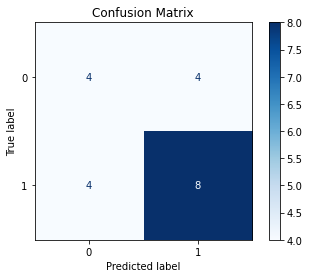

In [28]:
predictors = np.random.rand(100, 2)  # Sample features
labels = np.random.randint(0, 2, size=100)  # Sample labels (binary classification)

# Split the data into training and testing sets
XTrain, XTest, yTrain, yTest = train_test_split(predictors, labels, test_size=0.2, random_state=42)

# Create and train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(XTrain, yTrain)

# Evaluate the model on the training and testing data
train_accuracy = accuracy_score(yTrain, model.predict(XTrain))
test_accuracy = accuracy_score(yTest, model.predict(XTest))

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Generate predictions for the test data
yPred = model.predict(XTest)

# Create and display the confusion matrix
cm = confusion_matrix(yTest, yPred)
display_labels = model.classes_  # Assuming your classes are encoded as 0 and 1

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
plt.title("Confusion Matrix")
plt.show()

In [29]:
yTest

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0])

In [30]:
yPred

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0])